# ASIC Insolvency

Make sure you save the latest data in the cache dierctory and update cell 6, before running this notebook. 

## Python set-up

In [1]:
# system imports
from pathlib import Path

In [2]:
# analytic imports
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# local imports
from plotting import line_plot, set_chart_dir
from decompose import decompose

Could not import auto_arima from pmdarima


In [4]:
# plotting set-up
SOURCE = "Source: ASIC"
LFOOTER = "The first time a company enters external administration or has a controller appointed"
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/ASIC/"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
set_chart_dir(CHART_DIR)
for filename in Path(CHART_DIR).glob("*.png"):
    filename.unlink()
SHOW = False

## Data Capture

In [5]:
ASIC_CACHE_DIR = "./ASIC_CACHE/"

In [6]:
# YOU MUST DOWNLOAD THE LATEST DATA FROM THE ASIC WEBSITE
# and save it in the ASIC_CACHE_DIR directory
# Then amend the filename in the next line oif code ...
LATEST_DATA = (
    ASIC_CACHE_DIR
    + "asic-insolvency-statistics-series-1-and-series-2-published-2-april-2024.xlsx"
)

# see: https://asic.gov.au/regulatory-resources/find-a-document/statistics/insolvency-statistics/insolvency-statistics-current/


def get_asic_data():
    """Get the latest ASIC data."""

    asic_current_monthly = "1.3"
    asic_data = pd.read_excel(LATEST_DATA, sheet_name=asic_current_monthly, skiprows=10)
    asic_data = asic_data.dropna(how="all", axis=1)  # drop nan columns
    asic_data = asic_data.loc[asic_data["Period\n(month)"].notna()]  # drop total rows
    # get monthly PeriodIndex
    asic_data.index = pd.PeriodIndex(
        asic_data["Period\n(calendar year)"].astype(int).astype(str)
        + "-"
        + asic_data["Period\n(month)"],
        freq="M",
    )
    asic_data = asic_data.rename(columns={"Total": "Australia"})

    return asic_data


current_data = get_asic_data()

In [7]:
def get_asic_history() -> pd.DataFrame:
    """Get ASIC insolvency history data."""

    # get the monthly series-1 data
    asic_history_monthly = "1.2"
    asic_history = (
        ASIC_CACHE_DIR
        + "asic-insolvency-statistics-series-1-published-8-september-2022.xlsx"
    )
    asic_data = pd.read_excel(asic_history, sheet_name=asic_history_monthly, skiprows=4)

    # remove junk rows
    asic_data = asic_data.dropna(axis=0, how="all")
    asic_data = asic_data.iloc[1:-1]

    # fix the strange date format
    asic_data["Fin Year"] = asic_data.loc[asic_data["Australia"].isna(), "Period"]
    asic_data["Fin Year"] = asic_data["Fin Year"].ffill()
    asic_data = asic_data.dropna(thresh=8, axis=0)
    asic_data["Year"] = (
        asic_data["Fin Year"]
        .str.split("-")
        .str[0]
        .where(
            asic_data["Period"].isin(
                ("July", "August", "September", "October", "November", "December")
            ),
            other=asic_data["Fin Year"].str.split("-").str[1],
        )
    )
    asic_data.index = pd.PeriodIndex(
        asic_data["Year"] + "-" + asic_data["Period"], freq="M"
    )

    return asic_data


historic_data = get_asic_history()

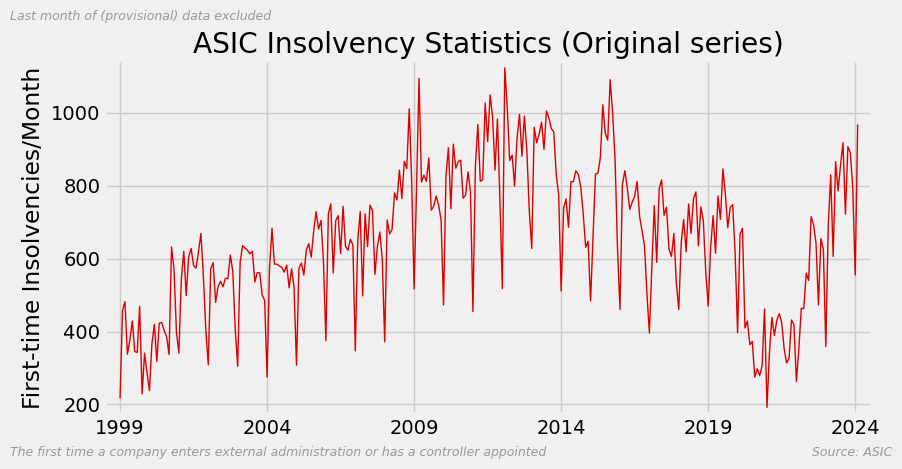

In [8]:
def combine_series(history: pd.Series, current: pd.Series) -> pd.Series:
    """Combine historic and current series."""
    combined_series = pd.concat([history, current], axis=0)
    combined_series = combined_series[~combined_series.index.duplicated(keep="last")]
    combined_series = combined_series.sort_index()
    return combined_series


def plot_original():
    """Plot original series."""
    combined_series = combine_series(
        historic_data["Australia"], current_data["Australia"]
    )
    line_plot(
        combined_series[:-1],
        title="ASIC Insolvency Statistics (Original series)",
        ylabel="First-time Insolvencies/Month",
        rfooter=SOURCE,
        lfooter=LFOOTER,
        lheader="Last month of (provisional) data excluded",
        width=1,
        show=True,
    )


plot_original()

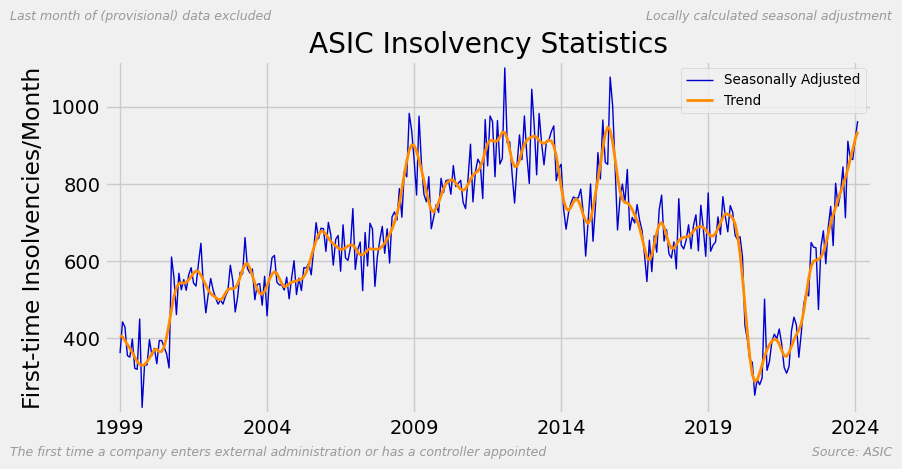

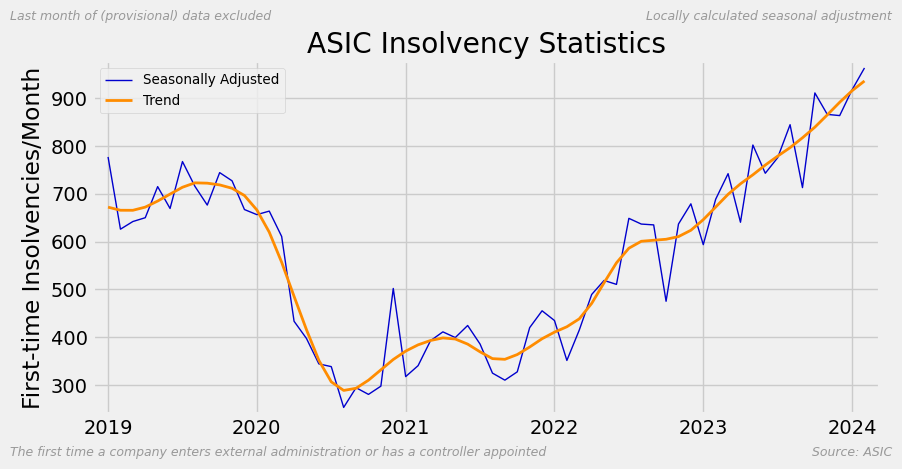

In [9]:
def plot_trend():
    """Plot trend and seasonally adjusted series."""
    combined_series = combine_series(
        historic_data["Australia"], current_data["Australia"]
    )
    decomp = decompose(s=combined_series.iloc[:-1], model="multiplicative")

    line_plot(
        decomp[["Seasonally Adjusted", "Trend"]],
        starts=(None, "2019-01"),
        title="ASIC Insolvency Statistics",
        width=(1, 2),
        ylabel="First-time Insolvencies/Month",
        rfooter=SOURCE,
        rheader="Locally calculated seasonal adjustment",
        lheader="Last month of (provisional) data excluded",
        lfooter=LFOOTER,
        show=True,
    )


plot_trend()

## Finished

In [10]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Wed Apr 03 2024 13:54:16

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

matplotlib: 3.8.3
pandas    : 2.2.1

Watermark: 2.4.3



In [11]:
print("done.")

done.
